# Extração da característica de relação sinal-ruído de dados de EEG

A ideia é utilizar dados fictícios de ruído e sinal "bom"., para criarmos a relação dos dois sinais e obter como resultado um sinal de interesse "limpo".

A partir deste sinal, podemos no contexto de caracterização de foco, ainda extrair os rítmos cerebrais ou então classificar sinais com a presença ou não de foco, de forma que as amostras de sinais extraídas de um buffer sejam rotuladas com com a presença ou não de foco.

Esta atividade pode ser realizada em conjunto com um classificador comumente utilizado, como é o caso do SVM. Neste caso, uma porcetagem das amostras são utilizadas para treino e o restante para teste (p.e. 30 e 70% respectivamente).

In [119]:
import mne
import numpy as np
from scipy.signal import welch
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [120]:
# definição do info (MNE)

n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")

# Leitura do dado basal (60 segundos) e amostra (10 minutos)

basal = '../dataset/s5/tF/OpenBCI-RAW-2023-11-06_19-56-20.txt'
basal_ob = np.loadtxt(basal, delimiter=',', skiprows=5, usecols=range(1, 9)).astype(np.float32)
data_noise_basal = basal_ob[21150:36150,:]    # 60 segundos de basal

inicio_amostra = sfreq * 120                  
final_amostra = inicio_amostra + sfreq * 60 * 10
data_amostra = basal_ob[inicio_amostra:final_amostra,:]      # 10 minutos de amostra


data_amostra_mne = mne.io.RawArray(data_amostra.T, info)
data_amostra_mne.notch_filter(freqs=60)
data_amostra_mne.filter(l_freq=4, h_freq=100)
freqs, data_amostra_mne_dominio_frequencia = welch(data_amostra_mne.get_data(), fs=250, nperseg=1024, noverlap=512)
scaler = StandardScaler()
data_amostra_mne_dominio_frequencia_normalizada = scaler.fit_transform(data_amostra_mne_dominio_frequencia)

data_noise_basal_mne = mne.io.RawArray(data_noise_basal.T, info)
data_noise_basal_mne.notch_filter(freqs=60)
data_noise_basal_mne.filter(l_freq=4, h_freq=100)
freqs, data_noise_basal_mne_dominio_frequencia = welch(data_noise_basal_mne.get_data(), fs=250, nperseg=1024, noverlap=512)
scaler = StandardScaler()
fft_result_basal = scaler.fit_transform(data_noise_basal_mne_dominio_frequencia)


Creating RawArray with float64 data, n_channels=8, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   599.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

[0, 0, 0, 1]
Amostra alvo: 1
Amostra descarte: 0
[0, 0, 0, 2]
Amostra alvo: 2
Amostra descarte: 0
[0, 0, 0, 3]
Amostra alvo: 3
Amostra descarte: 0
[0, 0, 0, 4]
Amostra alvo: 4
Amostra descarte: 0
[0, 0, 0, 5]
Amostra alvo: 5
Amostra descarte: 0
[0, 0, 0, 6]
Amostra alvo: 6
Amostra descarte: 0
[0, 0, 0, 7]
Amostra alvo: 7
Amostra descarte: 0
[0, 0, 0, 8]
Amostra alvo: 8
Amostra descarte: 0
[0, 0, 0, 9]
Amostra alvo: 9
Amostra descarte: 0
[0, 0, 0, 10]
Amostra alvo: 10
Amostra descarte: 0
[0, 0, 0, 11]
Amostra alvo: 11
Amostra descarte: 0
[0, 0, 0, 12]
Amostra alvo: 12
Amostra descarte: 0
[0, 0, 0, 13]
Amostra alvo: 13
Amostra descarte: 0
[0, 0, 0, 14]
Amostra alvo: 14
Amostra descarte: 0
[0, 0, 0, 15]
Amostra alvo: 15
Amostra descarte: 0
[0, 0, 0, 16]
Amostra alvo: 16
Amostra descarte: 0
[0, 0, 0, 17]
Amostra alvo: 17
Amostra descarte: 0
[0, 0, 0, 18]
Amostra alvo: 18
Amostra descarte: 0
[0, 0, 0, 19]
Amostra alvo: 19
Amostra descarte: 0
[0, 0, 0, 20]
Amostra alvo: 20
Amostra descarte: 

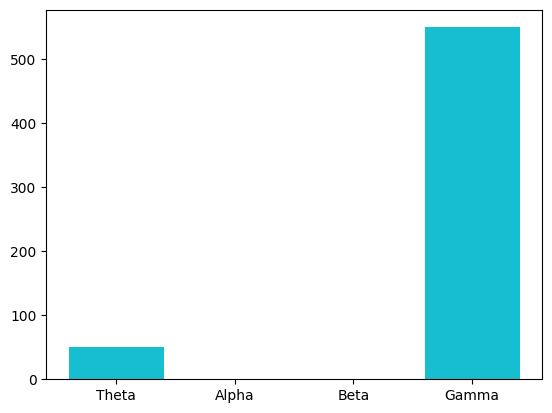

In [121]:
sr = 250            # taxa de amostragem
tamanho_amostra = 10 * 60
tamanho_amostra_pontos = tamanho_amostra * sr
tamanho_buffer = 5
tamanho_buffer_pontos = tamanho_buffer * sr
passo = 1 * 250
overlap = 4 * 250

# Definir os limites das bandas de frequência (em Hz)
theta_band = (4, 8)       # Theta: 4 - 8 Hz
alpha_band = (8, 13)      # Alpha: 8 - 13 Hz
beta_band = (13, 30)      # Beta: 13 - 30 Hz
gamma_band = (30, 100)    # Gamma: 30 - 100 Hz

# criando amostras de 5 segundos
amostras_alvo = []
amostras_descarte = []
amostras_theta = []

jump = 5            # 5 segundos de buffer
size = sr * jump    # quantidade de pontos avaliados


sample = {'f':[], 'nf':[]}
total_pc = {}
results = [0, 0, 0, 0]
for i in range(0, data_amostra_mne.n_times, passo):
    if i + size < data_amostra_mne.n_times:
        cut = data_amostra_mne.copy().crop(tmin=data_amostra_mne.times[i], tmax=data_amostra_mne.times[i]+jump)
    else:
        cut = data_amostra_mne.copy().crop(tmin=data_amostra_mne.times[i], tmax=data_amostra_mne.times[-1])  
    # Número de pontos por segmento
    nperseg = 128
    # Quantidade de sobreposição entre segmentos
    noverlap = nperseg // 2
    #cut.set_eeg_reference(ref_channels='average')
    cut = cut.get_data()

        # realizando a média dos 8 eletrodos
    # no caso do trabalho, analizar os canais separadamente.
    #   Para isso, vamos aplicar o filtro espacial, no qual
    #   podemos utilizar algoritmos específicos para a análise
    #   de EEG utilizando o CAR (Common Average Reference).

    freqs, psd = welch(cut, fs=sr, nperseg=nperseg, noverlap=noverlap)
    psd_media = np.average(psd, axis=0)

    # Encontrar os índices correspondentes às frequências de interesse
    theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
    alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
    beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
    gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]

    # Calcular a potência em cada banda de frequência por meio da integração da PSD
    bands = [np.sum(psd_media[theta_idxs]), np.sum(psd_media[alpha_idxs]), np.sum(psd_media[beta_idxs]), np.sum(psd_media[gamma_idxs])]
    # calculando a pontuação de cada banda para mostrar a porcentagem futura
    results[np.argmax(bands)] += 1
    if np.argmax(bands) == 2 or np.argmax(bands) == 3:
        sample['f'].append(psd_media)
    else:
        sample['nf'].append(psd_media)
    print(results)
    plot = plt.bar(['Theta', 'Alpha', 'Beta', 'Gamma'], results)

    print("Amostra alvo: " + str(len(sample['f'])))
    print("Amostra descarte: " + str(len(sample['nf'])))


In [122]:
# Estimando o ruído de fundo (utilizando o sinal basal)

# média da potência no intervalo de tempo sem estímulo
base_power = np.average(fft_result_basal)
# média das médias de potência de todos os canais para estimar o ruído de fundo
estimated_background_noise = base_power
print(estimated_background_noise)

-1.1773125251385675e-16


In [123]:
# Inicializando a lista com a soma de 'f' e 'nf' do sample
lista = sample['f'] + sample['nf']

scaler = StandardScaler()
listaNormalizada = scaler.fit_transform(lista)

# Forçando (estragando) valor de "estimated_background_noise" para não sobrar valores negativos
target_amplitudes_adjusted = listaNormalizada - estimated_background_noise

# Subtraindo o ruído de fundo das amplitudes
narrow_band_SNR = 10 * np.log2(target_amplitudes_adjusted / estimated_background_noise)
print(narrow_band_SNR)
print(narrow_band_SNR.shape)

# Calculando a potência total
total_power = np.sum(target_amplitudes_adjusted)

# Calculando o wide_band_SNR
wide_band_SNR = 10 * np.log10(target_amplitudes_adjusted / total_power)
print(wide_band_SNR)
print(wide_band_SNR.shape)


[[495.71279185 501.63761809 503.58041986 ...          nan 524.21769728
  528.78445945]
 [499.20722889 502.29336815 504.04877205 ...          nan 510.23870676
  512.80029025]
 [499.92370763 502.01769943 504.95765729 ...          nan 514.75237566
  508.09445802]
 ...
 [         nan          nan          nan ... 516.45808364          nan
  528.77757795]
 [         nan          nan          nan ... 524.39800765          nan
  530.66626682]
 [         nan          nan          nan ... 533.92582217 504.78352796
  526.87749144]]
(600, 65)
[[ 98.5844229  100.36797332 100.95281493 ...          nan 107.16525446
  108.53998685]
 [ 99.63635327 100.56537376 101.09380298 ...          nan 102.957159
  103.72827247]
 [ 99.85203486 100.4823892  101.3674047  ...          nan 104.31590873
  102.31167581]
 ...
 [         nan          nan          nan ... 104.829378            nan
  108.53791532]
 [         nan          nan          nan ... 107.21953329          nan
  109.10646732]
 [         nan          

/tmp/ipykernel_9506/3815935190.py:11: RuntimeWarning: invalid value encountered in log2
  narrow_band_SNR = 10 * np.log2(target_amplitudes_adjusted / estimated_background_noise)
/tmp/ipykernel_9506/3815935190.py:19: RuntimeWarning: invalid value encountered in log10
  wide_band_SNR = 10 * np.log10(target_amplitudes_adjusted / total_power)


Acurácia: 0.9666666666666667
Relatório de classificação:
               precision    recall  f1-score   support

           0       0.93      0.74      0.82        19
           1       0.97      0.99      0.98       161

    accuracy                           0.97       180
   macro avg       0.95      0.87      0.90       180
weighted avg       0.97      0.97      0.96       180



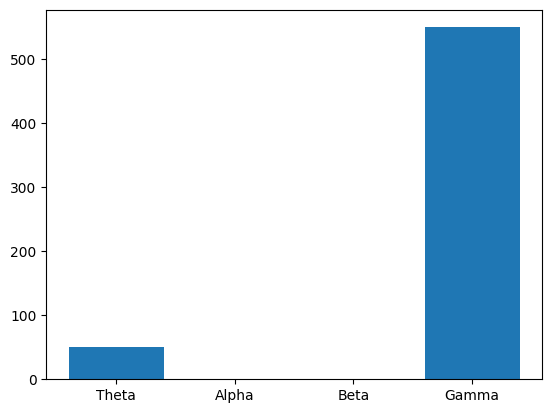

In [124]:
# Dividindo as amostras em treino e teste
features = sample['f'] + sample['nf']
labels = [1] * len(sample['f']) + [0] * len(sample['nf'])  # 1 para foco (Beta/Gamma) e 0 para não foco

# Dividir os dados em treino (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Transformar as amostras para um formato utilizável (normalização)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Criando o classificador SVM
svm_model = SVC(kernel='linear')

# Aplicando a seleção de características (RFE)
selector = RFE(svm_model, n_features_to_select=10, step=1)  # Reduzindo para 10 características mais relevantes
selector = selector.fit(X_train_scaled, y_train)

# Treinando o modelo SVM com as características selecionadas
svm_model.fit(X_train_scaled, y_train)

# Realizando a predição
y_pred = svm_model.predict(X_test_scaled)

# Avaliação do modelo
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

# Plotando as bandas de frequência novamente para ver os resultados
plt.bar(['Theta', 'Alpha', 'Beta', 'Gamma'], results)
plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Inicializando a lista com a soma de 'f' e 'nf' do sample
lista = sample['f'] + sample['nf']

# Verificar e tratar valores NaN ou Inf na lista
lista = np.nan_to_num(lista, nan=0.0, posinf=0.0, neginf=0.0)

scaler = StandardScaler()
listaNormalizada = scaler.fit_transform(lista)

# Forçando (estragando) valor de "estimated_background_noise" para não sobrar valores negativos
target_amplitudes_adjusted = listaNormalizada - estimated_background_noise

# Evitar divisões por zero adicionando uma pequena constante ao denominador
epsilon = 1e-10
target_amplitudes_adjusted = np.where(target_amplitudes_adjusted == 0, epsilon, target_amplitudes_adjusted)

# Subtraindo o ruído de fundo das amplitudes
narrow_band_SNR = 10 * np.log2(target_amplitudes_adjusted / (estimated_background_noise + epsilon))
print(narrow_band_SNR)
print(narrow_band_SNR.shape)

# Calculando a potência total
total_power = np.sum(target_amplitudes_adjusted)

# Evitar divisões por zero adicionando uma pequena constante ao denominador
total_power = total_power if total_power != 0 else epsilon

# Calculando o wide_band_SNR
wide_band_SNR = 10 * np.log10(target_amplitudes_adjusted / total_power)
print(wide_band_SNR)
print(wide_band_SNR.shape)